We are going to scrap the pib table from [this wikipedia article]("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal))
using the requests and beautiful soup librairies.

Later on, we will load other data sources with pandas, and use the regex librairy re.

pyplot will be used for adjusting pandas' plotting options.

In [1]:
import requests
import bs4
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

These two functions are designed to extract the contents of interest out of the table data cell from the wikipedia table

In [2]:
def extract_number(cell):
    try :
        return re.findall(r'[0-9]*', cell.contents[0].replace(",",''))[0]
    except :
        return 
    
def extract_country(cell):
        try :
            return cell.contents[1].contents[0]
        except : 
            return 

Let's load our additional datasets and normalize the country name column.

In [9]:
countries_geo=pd.read_csv("./datasets/Country_List_ISO_3166_Codes_Latitude_Longitude.csv")
country_data=pd.read_excel('./datasets/Countries of the world.xls', header=2)
country_units= country_data.loc[0]
country_data=country_data[1:]
country_data['n_country'] = country_data.Country.apply(lambda n: n.lower().replace(" ",""))


Ok, let's extract the table from Wikipedia:

In [10]:
doc = requests.get("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)").content
bdoc=bs4.BeautifulSoup(doc)
tables =bdoc.find_all('table')

table=tables[2]
trs= table.find_all('tr')
rdatae=[tr.find_all('td') for tr in trs]
countries= []
pibs = []
for row in rdatae[2:]:
    pib = extract_number(row[2])
    country = extract_country(row[1])
    countries.append(country)
    pibs.append(pib)

And here is the dataframe:

In [ ]:
country_pib=pd.DataFrame(list(zip(countries, pibs)), columns=['country', 'pib'])
country_pib['n_country']=country_pib.country.apply(lambda n: (n or '').lower().replace(" ",""))

Some renamings and preprocessing

In [38]:
countries_geoloc=countries_geo[['Country', 'Latitude (average)', 'Longitude (average)', 'Alpha-2 code']].rename({'Latitude (average)': 'lat', 'Longitude (average)': 'lon', 'Alpha-2 code': "code"}, axis=1)
countries_geoloc['n_country']=countries_geoloc.Country.apply(lambda n: (n or '').lower().replace(" ",""))

Alright, let's merge our datasources !

In [14]:
country_data=country_pib.merge(country_data, on='n_country').merge(countries_geoloc[['n_country', 'lat','lon','code']], on='n_country')
country_data.pib = country_data.pib.astype(int)

And compute the PIB to population ratio

In [22]:
country_data['pib_per_pop'] = country_data.pib/country_data.Population

In [ ]:
#country_data.to_csv("./datasets/country_data.csv")


In order to see which countries have the highest PIB by regions, we'll use pandas' groupby function

In [253]:
regional=country_data.groupby(['Region'])

This function generates a DataFrameGroupBy object that can to be aggregated.

In [256]:
regional

The aggregate or agg method takes a function of a dataframe. 
The dataframe that will be passed to this function is the subdataframe inside the groups.
For instance, if we want to recover the line with the highest pib, we can 
- first get its index with the idxmax function
- then recover the whole line with the loc function

In [267]:
getmaxpib= lambda df: df.loc[df.pib.idxmax()]
getminpib= lambda df: df.loc[df.pib.idxmin()]

In [268]:
maxregional = regional.aggregate(getmaxpib)
minregional = regional.aggregate(getminpib)

In [269]:
maxregional

,country,pib,n_country,Country,Population,Area,Pop. Density,Coastline,Net migration,Infant mortality,...,Birthrate,Deathrate,Agriculture,Industry,Service,lat,lon,code,pib_per_pop,A
Region,,,,,,,,,,,,,,,,,,,,,
ASIA (EX. NEAR EAST),China,12014610.0,china,China,1.313974e+09,9596960.0,136.92,0.15,-0.40,24.18,...,13.25,6.97,0.125,0.473,0.403,35.0,105.0,CN,0.009144,1
BALTICS,Lithuania,47263.0,lithuania,Lithuania,3.585906e+06,65200.0,55.00,0.14,-0.71,6.89,...,8.75,10.98,0.055,0.325,0.620,56.0,24.0,LT,0.013180,1
C.W. OF IND. STATES,Kazakhstan,160839.0,kazakhstan,Kazakhstan,1.523324e+07,2717300.0,5.61,0.00,-3.35,29.21,...,16.00,9.42,0.067,0.386,0.547,48.0,68.0,KZ,0.010558,1
EASTERN EUROPE,Poland,524886.0,poland,Poland,3.853687e+07,312685.0,123.25,0.16,-0.49,8.51,...,9.85,9.89,0.050,0.311,0.640,52.0,20.0,PL,0.013620,1
LATIN AMER. & CARIB,Brazil,2054969.0,brazil,Brazil,1.880782e+08,8511965.0,22.10,0.09,-0.03,29.61,...,16.56,6.17,0.084,0.400,0.516,-10.0,-55.0,BR,0.010926,1
NEAR EAST,Turkey,849480.0,turkey,Turkey,7.041396e+07,780580.0,90.21,0.92,0.00,41.04,...,16.62,5.97,0.117,0.298,0.585,39.0,35.0,TR,0.012064,1
NORTHERN AFRICA,Egypt,237073.0,egypt,Egypt,7.888701e+07,1001450.0,78.77,0.24,-0.22,32.59,...,22.94,5.23,0.149,0.357,0.493,27.0,30.0,EG,0.003005,1
NORTHERN AMERICA,United States,19390600.0,unitedstates,United States,2.984442e+08,9631420.0,30.99,0.21,3.41,6.50,...,14.14,8.26,0.010,0.204,0.787,38.0,-97.0,US,0.064972,1
OCEANIA,Australia,1379548.0,australia,Australia,2.026408e+07,7686850.0,2.64,0.34,3.98,4.69,...,12.14,7.51,0.038,0.262,0.700,-27.0,133.0,AU,0.068078,1


In [270]:
minregional

,country,pib,n_country,Country,Population,Area,Pop. Density,Coastline,Net migration,Infant mortality,...,Birthrate,Deathrate,Agriculture,Industry,Service,lat,lon,code,pib_per_pop,A
Region,,,,,,,,,,,,,,,,,,,,,
ASIA (EX. NEAR EAST),Bhutan,2321.0,bhutan,Bhutan,2279723.0,47000.0,48.50,0.00,0.00,100.44,...,33.65,12.70,0.258,0.379,0.363,27.5000,90.5000,BT,0.001018,0
BALTICS,Estonia,25973.0,estonia,Estonia,1324333.0,45226.0,29.28,8.39,-3.16,7.87,...,10.04,13.25,0.040,0.294,0.666,59.0000,26.0000,EE,0.019612,0
C.W. OF IND. STATES,Kyrgyzstan,7061.0,kyrgyzstan,Kyrgyzstan,5213898.0,198500.0,26.27,0.00,-2.45,35.64,...,22.80,7.08,0.353,0.208,0.439,41.0000,75.0000,KG,0.001354,0
EASTERN EUROPE,Albania,13001.0,albania,Albania,3581655.0,28748.0,124.59,1.26,-4.93,21.52,...,15.11,5.22,0.232,0.188,0.579,41.0000,20.0000,AL,0.003630,0
LATIN AMER. & CARIB,Dominica,608.0,dominica,Dominica,68910.0,754.0,91.39,19.63,-13.87,14.15,...,15.27,6.73,0.177,0.328,0.495,15.4167,-61.3333,DM,0.008823,0
NEAR EAST,Yemen,16511.0,yemen,Yemen,21456188.0,527970.0,40.64,0.36,0.00,61.50,...,42.89,8.30,0.135,0.472,0.393,15.0000,48.0000,YE,0.000770,0
NORTHERN AFRICA,Tunisia,40275.0,tunisia,Tunisia,10175014.0,163610.0,62.19,0.70,-0.57,24.77,...,15.52,5.13,0.132,0.318,0.550,34.0000,9.0000,TN,0.003958,0
NORTHERN AMERICA,Canada,1652412.0,canada,Canada,33098932.0,9984670.0,3.31,2.02,5.96,4.75,...,10.78,7.80,0.022,0.294,0.684,60.0000,-95.0000,CA,0.049923,1
OCEANIA,Tuvalu,40.0,tuvalu,Tuvalu,11810.0,26.0,454.23,92.31,0.00,20.03,...,22.18,7.11,0.166,0.272,0.562,-8.0000,178.0000,TV,0.003387,0


However, it doesn't work straightforwardly when grouped over multiple indices:

In [560]:
country_data['A']=country_data.pib.apply(lambda x: int(x>country_data.pib.median()))
regional2 = country_data.groupby(['A', 'Region'])
regional2.agg(getmaxpib)

AttributeError: 'Series' object has no attribute 'pib'

In [562]:
country_data.drop('A', axis=1, inplace=True)

# Quick look at the data

First let's do some type casting

In [563]:
numeric=[]
labelcols=[]
for c in country_data.columns:
    try:
        country_data[c]= country_data[c].astype(float)
        numeric.append(c)
    except:
        labelcols.append(c)
        print(c)

country
n_country
Country
Region
code


And see the various correlations between these geoeconomic variables

In [564]:
country_data.corr()

,pib,Population,Area,Pop. Density,Coastline,Net migration,Infant mortality,GDP,Literacy,Phones,...,Climate,Birthrate,Deathrate,Agriculture,Industry,Service,lat,lon,pib_per_pop,class
pib,1.000000,0.585281,0.664577,-0.009928,-0.054350,0.090515,-0.162823,0.300562,0.141696,0.377625,...,0.123084,-0.196199,-0.076558,-0.176699,0.015031,0.152748,0.145794,-0.050556,0.178400,0.153803
Population,0.585281,1.000000,0.541889,-0.006507,-0.064522,0.007337,-0.008093,-0.030038,-0.031969,0.018676,...,-0.028233,-0.072808,-0.071548,-0.020922,0.082831,-0.052318,0.052401,0.117903,-0.050935,0.146889
Area,0.664577,0.541889,1.000000,-0.084613,-0.100425,0.098476,-0.049416,0.146105,0.046394,0.188101,...,-0.098420,-0.091731,-0.061232,-0.097013,0.091257,0.011406,-0.013489,-0.074778,0.074103,0.193390
Pop. Density,-0.009928,-0.006507,-0.084613,1.000000,0.199711,0.229506,-0.147206,0.205609,0.080480,0.194969,...,-0.018693,-0.172494,-0.140670,-0.149079,-0.106591,0.233659,-0.013190,0.170469,0.184508,0.066507
Coastline,-0.054350,-0.064522,-0.100425,0.199711,1.000000,0.005808,-0.101505,-0.017614,0.091471,0.057383,...,-0.033179,-0.038550,-0.141165,-0.095388,-0.174380,0.243632,-0.119412,0.223608,-0.002184,-0.022067
Net migration,0.090515,0.007337,0.098476,0.229506,0.005808,1.000000,-0.013770,0.436426,-0.025500,0.271901,...,-0.100070,-0.068991,0.063419,-0.122534,0.082286,0.041016,0.155491,0.218070,0.495238,0.047128
Infant mortality,-0.162823,-0.008093,-0.049416,-0.147206,-0.101505,-0.013770,1.000000,-0.606174,-0.753782,-0.689352,...,-0.399687,0.853088,0.639614,0.694195,-0.029812,-0.617187,-0.343652,0.080442,-0.449051,-0.564846
GDP,0.300562,-0.030038,0.146105,0.205609,-0.017614,0.436426,-0.606174,1.000000,0.517687,0.888495,...,0.395471,-0.654977,-0.196393,-0.618616,0.031047,0.549618,0.454468,-0.055180,0.823914,0.362629
Literacy,0.141696,-0.031969,0.046394,0.080480,0.091471,-0.025500,-0.753782,0.517687,1.000000,0.614851,...,0.417040,-0.785761,-0.347076,-0.606917,0.060948,0.502351,0.277117,-0.072507,0.351064,0.534901
Phones,0.377625,0.018676,0.188101,0.194969,0.057383,0.271901,-0.689352,0.888495,0.614851,1.000000,...,0.493071,-0.756892,-0.247732,-0.638392,-0.030892,0.625791,0.504975,-0.102196,0.683325,0.383201


# Dimensional reduction

In [565]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [566]:
pipeline= Pipeline([
    ('imputer', Imputer()),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

In [614]:
labels = country_data.country.values
Xvalues= country_data[numeric].drop('pib', axis=1).values


In [615]:
pipeline.fit(Xvalues)
pcastep = pipeline.named_steps['pca']


In [618]:
imputer_strategy=['mean', 'median', 'most_frequent']
pca_n_components = list(range(2,10))
grid= GridSearchCV(pipeline, {'imputer__strategy': imputer_strategy,
                              'pca__n_components':pca_n_components
                             })

Best imputer strategy: mean
Best PCA n_components: 2


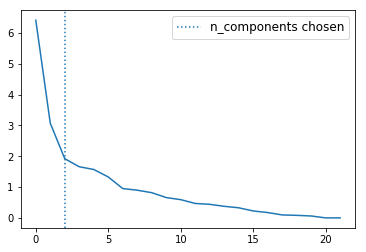

In [626]:
grid.fit(Xvalues)
best_est=grid.best_estimator_
print('Best imputer strategy: {}\nBest PCA n_components: {}'.format(best_est.named_steps['imputer'].strategy, best_est.named_steps['pca'].n_components))
plt.plot(pcastep.explained_variance_)
plt.axvline(grid.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))


In [627]:
steps= grid.best_estimator_.steps + [('kmeans', KMeans())]
classifier = Pipeline(steps)


In [679]:
classifier_grid = GridSearchCV(classifier,{
                                            'kmeans__n_clusters': [3,4,5,6]
                                            },n_jobs=-1)

In [680]:
classifier_grid.fit(Xvalues)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='..., n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kmeans__n_clusters': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [681]:
bestpca= grid.best_estimator_.named_steps['pca']
pd.DataFrame([dict(zip(numeric,comp)) for comp in bestpca.components_]).T

,0,1
Agriculture,0.016464,0.214731
Arable,-0.041084,-0.344259
Area,0.093643,0.027472
Birthrate,-0.175968,0.075664
Climate,-0.349991,0.091598
Coastline,0.104962,0.283667
Crops,-0.043747,0.470755
Deathrate,-0.306461,-0.036724
GDP,0.296944,-0.115560
Industry,0.270379,-0.156042


In [682]:
Xtrans = grid.transform(Xvalues)


In [683]:
print (classifier_grid.best_estimator_.named_steps['kmeans'].n_clusters)
Xclass = classifier_grid.predict(Xvalues)

6


In [684]:
clusters ={}
for xy, k in zip(Xtrans, Xclass):
    clusters.update({k:clusters.get(k,[])+[xy]})

In [685]:
tolist= lambda df:', '.join(df.map(lambda s: s.replace("  ", "").strip()).unique())
tolist(country_data.Region)

'NORTHERN AMERICA, ASIA (EX. NEAR EAST), WESTERN EUROPE, LATIN AMER. & CARIB, OCEANIA, NEAR EAST, EASTERN EUROPE, SUB-SAHARAN AFRICA, NORTHERN AFRICA, C.W. OF IND. STATES, BALTICS'

In [686]:
country_data['class'] = Xclass
country_data.groupby("class").agg({'Region':tolist, 'lat':'mean', 'lon': 'mean'})

,Region,lat,lon
class,,,
0,"SUB-SAHARAN AFRICA, ASIA (EX. NEAR EAST), NEAR...",5.531250,37.750000
1,"ASIA (EX. NEAR EAST), LATIN AMER. & CARIB, NEA...",10.243056,-1.138889
2,"NEAR EAST, EASTERN EUROPE, ASIA (EX. NEAR EAST...",33.692534,28.753448
3,"ASIA (EX. NEAR EAST), NORTHERN AMERICA, OCEANI...",21.775525,56.282263
4,"ASIA (EX. NEAR EAST), LATIN AMER. & CARIB, SUB...",5.614037,9.355263
5,"NORTHERN AMERICA, ASIA (EX. NEAR EAST), WESTER...",43.783996,20.720000


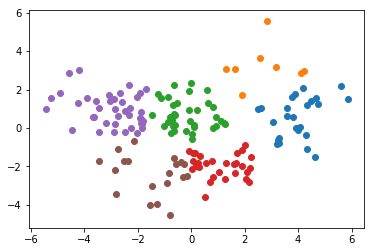

In [687]:
for xfit in clusters.values():
    plt.scatter([xy[0] for xy in xfit], [xy[1] for xy in xfit])

In [693]:
country_data_clusters=country_data.set_index(['class', 'Region', 'country']).sort_index()

In [700]:
country_data_clusters.loc[4]

pib  \
Region                              country                        
ASIA (EX. NEAR EAST)                Bangladesh          261374.0   
                                    Maldives              4520.0   
                                    Philippines         313419.0   
                                    Sri Lanka            87591.0   
LATIN AMER. & CARIB                 Dominica               608.0   
                                    Dominican Republic   75018.0   
                                    El Salvador          28023.0   
                                    Haiti                 8360.0   
OCEANIA                             Kiribati               186.0   
                                    Marshall Islands       199.0   
                                    Samoa                  844.0   
                                    Tonga                  437.0   
SUB-SAHARAN AFRICA                  Burundi               3393.0   
                                    Cape Verde            1728.0   
                                    Comoros                659.0   
                                    Ghana                47032.0   
                                    Rwanda                8918.0   
                                    Togo                  4797.0   
                                    Uganda               26349.0   

                                                                n_country  \
Region                              country                                 
ASIA (EX. NEAR EAST)                Bangladesh                 bangladesh   
                                    Maldives                     maldives   
                                    Philippines               philippines   
                                    Sri Lanka                    srilanka   
LATIN AMER. & CARIB                 Dominica                     dominica   
                                    Dominican Republic  dominicanrepublic   
                                    El Salvador                elsalvador   
                                    Haiti                           haiti   
OCEANIA                             Kiribati                     kiribati   
                                    Marshall Islands      marshallislands   
                                    Samoa                           samoa   
                                    Tonga                           tonga   
SUB-SAHARAN AFRICA                  Burundi                       burundi   
                                    Cape Verde                  capeverde   
                                    Comoros                       comoros   
                                    Ghana                           ghana   
                                    Rwanda                         rwanda   
                                    Togo                             togo   
                                    Uganda                         uganda   

                                                                    Country  \
Region                              country                                   
ASIA (EX. NEAR EAST)                Bangladesh                  Bangladesh    
                                    Maldives                      Maldives    
                                    Philippines                Philippines    
                                    Sri Lanka                    Sri Lanka    
LATIN AMER. & CARIB                 Dominica                      Dominica    
                                    Dominican Republic  Dominican Republic    
                                    El Salvador                El Salvador    
                                    Haiti                            Haiti    
OCEANIA                             Kiribati                      Kiribati    
                                    Marshall Islands      Marshall Islands    
                                    Samoa                         